# Regressão Linear para Validação

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error

In [60]:
pd.set_option('display.max_columns', 500)

In [61]:
df = pd.read_csv('../data/intermediate/dataset_regression_challenge_processed.csv', sep=';',decimal=',')

df = df[df.CondicaoVenda == 'Normal'].copy()

### Teste de Correlação
Utilizado para definir as melhores métricas a serem utilizadas no modelo

In [62]:
# Identificando variáveis com maiores correlações
df_corr = df.corr()
df_corr = pd.DataFrame(df_corr['PrecoVenda'])
df_corr = df_corr[df_corr['PrecoVenda']>0.6]

df_corr

,PrecoVenda
Qualidade,0.786850
AreaPorao,0.628819
AreaTerreo,0.610918
AreaConstruida,0.744517
CarrosGaragem,0.626678
AreaGaragem,0.608056
PrecoVenda,1.000000


Criando dummies para verificar se surgem novas métricas

In [63]:
df_temp = pd.get_dummies(df)

# Identificando variáveis com maiores correlações
df_corr = df_temp.corr()
df_corr = pd.DataFrame(df_corr['PrecoVenda'])
df_corr = df_corr[df_corr['PrecoVenda']>0.6]

df_corr

,PrecoVenda
Qualidade,0.786850
AreaPorao,0.628819
AreaTerreo,0.610918
AreaConstruida,0.744517
CarrosGaragem,0.626678
AreaGaragem,0.608056
PrecoVenda,1.000000


In [64]:
principal_vars = df_corr.index

In [65]:
del df_corr
del df_temp

### Regressão Usando Statsmodels

In [66]:
# Modelo
model = smf.ols(
    formula= 'PrecoVenda ~ Qualidade + AreaPorao + AreaTerreo + AreaConstruida + CarrosGaragem + AreaGaragem',
    data=df
)

#Resultados
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             PrecoVenda   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     869.4
Date:                Tue, 23 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:57:35   Log-Likelihood:                -14052.
No. Observations:                1198   AIC:                         2.812e+04
Df Residuals:                    1191   BIC:                         2.815e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -9.072e+04   4366.315    -20.

In [67]:
# Usando Transformação Logarítimica

dflog = df
dflog['PrecoVenda'] = np.log(dflog['PrecoVenda'])

In [68]:
# Modelo
model_log = smf.ols(
    formula= 'PrecoVenda ~ Qualidade + AreaPorao + AreaTerreo + AreaConstruida + CarrosGaragem + AreaGaragem',
    data=dflog
)

#Resultados
results_log = model_log.fit()
print(results_log.summary())

                            OLS Regression Results                            
Dep. Variable:             PrecoVenda   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     991.1
Date:                Tue, 23 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:57:36   Log-Likelihood:                 574.46
No. Observations:                1198   AIC:                            -1135.
Df Residuals:                    1191   BIC:                            -1099.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         10.5862      0.022    486.

Como os resultados foram melhores, seguiremos com a variável de interesse transformada
### Comparando com o SKLEARN

In [69]:
dflog = dflog[principal_vars]
df_sklearn = pd.get_dummies(dflog.fillna(np.mean),drop_first=True)


In [70]:
# Criando a equação do modelo

# No SKLEARN passamos 2 parâmetros
# X = DataFrame com variáveis explicativas
# y = Variável Resposta

lr = linear_model.LinearRegression()
predicted = lr.fit(X=df_sklearn, y=df_sklearn.PrecoVenda)

In [71]:
# Obtendo os coeficientes
values = np.append(predicted.intercept_,predicted.coef_)

# Obtem os nomes das colunas 
names = np.append('intercept', df_sklearn.columns)

# Cria um DataFrame com os resultados
results = pd.DataFrame(
    values, index=names,
    columns=['coef']
)

results

,coef
intercept,1.598721e-14
Qualidade,-1.776152e-15
AreaPorao,6.299215e-17
AreaTerreo,-6.155558e-17
AreaConstruida,2.314772e-17
CarrosGaragem,2.043397e-14
AreaGaragem,-1.594319e-16
PrecoVenda,1.000000e+00


In [72]:
df_predicted = predicted.predict(df_sklearn)
df_predicted = pd.DataFrame(df_predicted)

df_sklearn['predicted'] = df_predicted

df_sklearn.head()

,Qualidade,AreaPorao,AreaTerreo,AreaConstruida,CarrosGaragem,AreaGaragem,PrecoVenda,predicted
0,7,856,856,1710,2,548,12.247694,12.247694
1,6,1262,1262,1262,2,460,12.109011,12.109011
2,7,920,920,1786,2,608,12.317167,12.317167
4,8,1145,1145,2198,3,836,12.429216,11.870600
5,5,796,796,1362,2,480,11.870600,12.634603


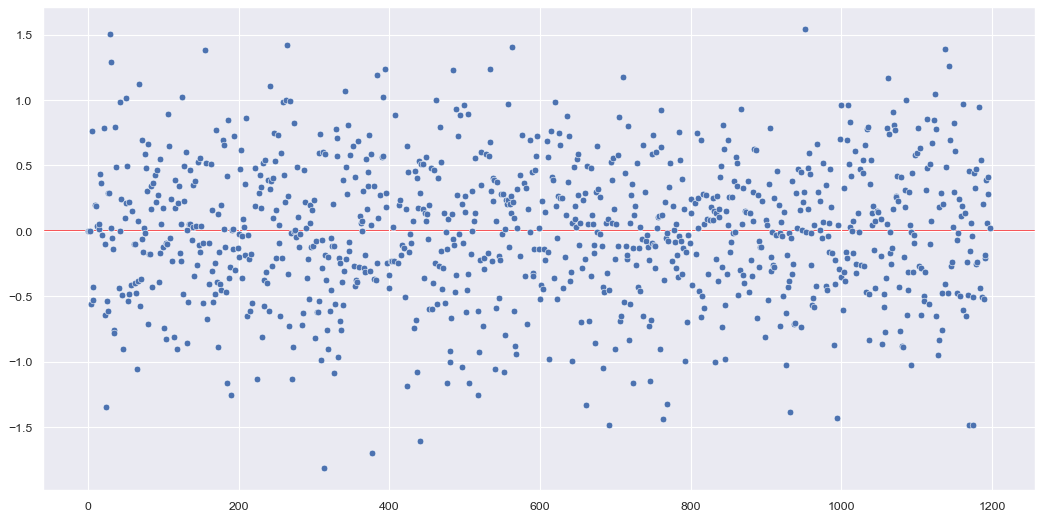

In [73]:
sns.set_theme(style='darkgrid')
plt.figure(figsize=[16,8],dpi=80)
sns.scatterplot(x=df_sklearn.index, y= df_sklearn.predicted - df_sklearn.PrecoVenda)
plt.axhline(color='red', alpha= 0.8, zorder=-1)
plt.show()